# Locality Reduction

- From [Xia et al.](https://arxiv.org/pdf/1706.00271.pdf), we have the following relation to locality reduction when minimizing Ising hamiltonian.
- $\begin{array}{l}
\min \left(\sigma_{z}^{1} \sigma_{z}^{2} \prod_{i=3}^{n} \sigma_{z}^{i}\right) \\
=\min \left(8 \frac{1+\sigma_{z}^{1}}{2} \frac{1+\sigma_{z}^{2} 1+\prod_{i=3}^{n} \sigma_{z}^{i}}{2}-8 \frac{1+\sigma_{z}^{1}+\sigma_{z}^{2}+\prod_{i=3}^{n} \sigma_{z}^{i}+\sigma_{z}^{1} \sigma_{z}^{2}+\sigma_{z}^{1} \prod_{i=3}^{n} \sigma_{z}^{i}+\sigma_{z}^{2} \prod_{i=3}^{n} \sigma_{z}^{i}}{8}\right) \\
=\min \left(7+\prod_{i=3}^{n} \sigma_{z}^{i}-3 \sigma_{z}^{1}-3 \sigma_{z}^{2}+6 \sigma_{z}^{n+1}+2 \prod_{i=3}^{n+1} \sigma_{z}^{i}-\sigma_{z}^{1} \prod_{i=3}^{n} \sigma_{z}^{i}-\sigma_{z}^{2} \prod_{i=3}^{n} \sigma_{z}^{i}-4 \sigma_{z}^{1} \sigma_{z}^{n+1}-4 \sigma_{z}^{2} \sigma_{z}^{n+1}+\sigma_{z}^{1} \sigma_{z}^{2}\right)
\end{array}$


 - $\begin{array}{l}
\min \left(-\sigma_{z}^{1} \sigma_{z}^{2} \prod_{i=3}^{n} \sigma_{z}^{i}\right) \\
=\min \left(-8 \frac{1+\sigma_{z}^{1}}{2} \frac{1+\sigma_{z}^{2}}{2} \frac{1+\prod_{z=3}^{n} \sigma_{z}^{i}}{2}+8 \frac{1+\sigma_{z}^{1}+\sigma_{z}^{2}+\prod_{i=3}^{n} \sigma_{z}^{i}+\sigma_{z}^{1} \sigma_{z}^{2}+\sigma_{z}^{1} \prod_{i=3}^{n} \sigma_{z}^{i}+\sigma_{z}^{2} \prod_{i=3}^{n} \sigma_{z}^{i}}{8}\right) \\
=\min \left(5-\prod_{i=3}^{n} \sigma_{z}^{i}-\sigma_{z}^{1}-\sigma_{z}^{2}+2 \sigma_{z}^{n+1}-2 \prod_{i=3}^{n+1} \sigma_{z}^{i}+\sigma_{z}^{1} \prod_{i=3}^{n} \sigma_{z}^{i}+\sigma_{z}^{2} \prod_{i=3}^{n} \sigma_{z}^{i}-4 \sigma_{z}^{1} \sigma_{z}^{n+1}-4 \sigma_{z}^{2} \sigma_{z}^{n+1}+3 \sigma_{z}^{1} \sigma_{z}^{2}\right)
\end{array}$

- Let's implement this to reduce any k-local Ising hamiltonian into 2-local.
- We use SymPy to manipulate symbolic expression of the hamiltonian.

In [1]:
import itertools

from sympy import *

from object_einsum import object_einsum
import re

sigmas = symbols('sigma1:5')

show_log = False

In [2]:

def reduce_positive_term_locality(sigmas, ancilla_symbol):
    if show_log:
        print("Reducing a term: ", prod(sigmas))
    sigma_np1 = ancilla_symbol # np1 means n+1, Additional sigma required to reduce locality
    res = 7 + prod(sigmas[2:]) - 3 * sigmas[0] - 3 * sigmas[1] + 6*sigma_np1 + 2 * prod(sigmas[2:]) * sigma_np1 - sigmas[0] * prod(sigmas[2:]) - sigmas[1] *prod(sigmas[2:]) - 4 * sigmas[0] * sigma_np1 - 4 * sigmas[1] * sigma_np1 + prod(sigmas[0:2])
    return res

def reduce_negative_term_locality(sigmas, ancilla_symbol):
    if show_log:
        print("Reducing a term: ", prod(sigmas))
    sigma_np1 = ancilla_symbol # np1 means n+1, Additional sigma required to reduce locality
    res = 5 - prod(sigmas[2:]) - sigmas[0] - sigmas[1] + 2 * sigma_np1 - 2 * prod(sigmas[2:]) * sigma_np1 + sigmas[0] * prod(sigmas[2:]) + sigmas[1] * prod(sigmas[2:]) - 4 * sigmas[0] * sigma_np1 - 4 * sigmas[1] * sigma_np1 + 3 * sigmas[0] * sigmas[1]
    return res

# Split coefficient(=float) and symbols from a SymPy term
def separate_to_coeff_and_symbols(expr):
    syms = []
    coeffs = []
    for elem in Mul.make_args(expr):
       if type(elem) == Symbol:
           syms.append(elem)
       else:
           coeffs.append(elem)
    if coeffs:
       coeff = coeffs[0]
    else:
       coeff = 1
    return coeff, syms


# Reduce locality from k to k-1
def reduce_one_locality(expr, variable_name, maximum_index, to_locality):
    next_variable_index = maximum_index + 1
    reduced_expr = 0
    current_locality = 0
    # Split into each terms only contains multiplication, `expand` forces SymPy to not factor out any term
    for term in Add.make_args(expand(expr)):
        coeff, syms = separate_to_coeff_and_symbols(term)
        current_locality = max(current_locality, len(syms))
        if current_locality <= to_locality:
            if show_log:
                print("Skipping reduction on term: ", term)
            reduced_expr += term
            continue
        next_ancilla = Symbol(f'{variable_name}{next_variable_index}')
        if coeff > 0 :
            this_reduced_expr = reduce_positive_term_locality(syms, next_ancilla)
        else:
            # `reduce_negative_term_locality` returns expression to be minimized as negative, so coefficient must be negated
            coeff *= -1
            this_reduced_expr = reduce_negative_term_locality(syms, next_ancilla)
        reduced_expr += coeff * this_reduced_expr
        if show_log:
            print(f"Reduced a term into {this_reduced_expr}. Added index is ", next_variable_index)
        next_variable_index += 1
    next_maximum_index = next_variable_index - 1
    reduced_locality = current_locality - 1
    return reduced_expr, next_maximum_index, reduced_locality


# Reduce locality to `to_locality`
# Maximum_index is the largest index of `variable_name` in expr
# e.g. sigma0 ~ sigma3 is used , then maximum_index is 3 and variable_name is sigma
def reduce_locality(expr, variable_name, maximum_index, to_locality=2):
    reduced_expr, next_maximum_index, locality = reduce_one_locality(expr, variable_name, maximum_index, to_locality)
    if show_log:
        print(f"Reduced locality to {locality}")
    if locality < to_locality:
        return expr
    elif locality == to_locality:
        return reduced_expr
    else:
        return reduce_locality(reduced_expr, variable_name, next_maximum_index)
expr = prod(symbols("sigma0:4"))
reduced_expr, total_variables_count, locality = reduce_one_locality(expr, variable_name='sigma', maximum_index=3, to_locality=3)
print("Variables count ", total_variables_count, ", Locality ", locality)
reduced_expr

Variables count  4 , Locality  3


sigma0*sigma1 - sigma0*sigma2*sigma3 - 4*sigma0*sigma4 - 3*sigma0 - sigma1*sigma2*sigma3 - 4*sigma1*sigma4 - 3*sigma1 + 2*sigma2*sigma3*sigma4 + sigma2*sigma3 + 6*sigma4 + 7

In [3]:
reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)

sigma0*sigma1 + 3*sigma0*sigma2 + sigma0*sigma3 - 4*sigma0*sigma4 - 4*sigma0*sigma5 - 4*sigma0 + 3*sigma1*sigma2 + sigma1*sigma3 - 4*sigma1*sigma4 - 4*sigma1*sigma6 - 4*sigma1 + 5*sigma2*sigma3 - 2*sigma2*sigma4 - 4*sigma2*sigma5 - 4*sigma2*sigma6 - 8*sigma2*sigma7 - 8*sigma2 - 2*sigma3*sigma4 - 2*sigma3*sigma5 - 2*sigma3*sigma6 - 8*sigma3*sigma7 - 8*sigma3 + 4*sigma4*sigma7 + 8*sigma4 + 2*sigma5 + 2*sigma6 + 12*sigma7 + 31

In [4]:
import numpy as np

# Create float coeff symbol expression of 4 local Ising hamiltonian
def construct_hamiltonian_expr(E0, h, J, K, L):
    expr = 0
    num_variables = len(h)
    sigmas = np.array(symbols(f'sigma0:{num_variables}'), dtype=np.object)
    expr += np.dot(h, sigmas)
    expr += np.dot(sigmas, np.dot(J, sigmas))
    expr += object_einsum("ijk,i,j,k", K, sigmas, sigmas, sigmas)
    expr += object_einsum("ijkl,i,j,k,l", L, sigmas, sigmas, sigmas, sigmas)
    expr += E0
    return expr

def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]

    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [5]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")
expr = construct_hamiltonian_expr(E0, h, J, K, L)


In [6]:
reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
reduced_expr

1.14210965058458*sigma0*sigma1 - 0.67968392106266*sigma0*sigma10 + 0.925242519593277*sigma0*sigma2 + 0.00800736579361166*sigma0*sigma3 - 0.714671116297483*sigma0*sigma4 - 1.05802785499273*sigma0*sigma6 - 0.0335083292046345*sigma0*sigma7 - 0.67968392106266*sigma0*sigma8 - 1.48857130433511*sigma0 - 0.67968392106266*sigma1*sigma11 + 0.944190884810842*sigma1*sigma2 - 0.00569167520140076*sigma1*sigma3 - 0.714671116297483*sigma1*sigma4 - 0.67968392106266*sigma1*sigma5 - 1.05802785499273*sigma1*sigma6 - 0.67968392106266*sigma1*sigma8 - 1.80733072276374*sigma1 - 0.67968392106266*sigma10*sigma2 - 0.33984196053133*sigma10*sigma3 + 0.33984196053133*sigma10 - 0.67968392106266*sigma11*sigma2 - 0.33984196053133*sigma11*sigma3 + 0.33984196053133*sigma11 + 0.415176957314479*sigma2*sigma3 - 0.67968392106266*sigma2*sigma5 - 0.529013927496364*sigma2*sigma6 - 0.0335083292046345*sigma2*sigma7 - 0.33984196053133*sigma2*sigma8 - 1.35936784212532*sigma2*sigma9 - 2.01617346082703*sigma2 + 0.357335558148741*sig

In [7]:
expand(reduced_expr)

1.14210965058458*sigma0*sigma1 - 0.67968392106266*sigma0*sigma10 + 0.925242519593277*sigma0*sigma2 + 0.00800736579361166*sigma0*sigma3 - 0.714671116297483*sigma0*sigma4 - 1.05802785499273*sigma0*sigma6 - 0.0335083292046345*sigma0*sigma7 - 0.67968392106266*sigma0*sigma8 - 1.48857130433511*sigma0 - 0.67968392106266*sigma1*sigma11 + 0.944190884810842*sigma1*sigma2 - 0.00569167520140076*sigma1*sigma3 - 0.714671116297483*sigma1*sigma4 - 0.67968392106266*sigma1*sigma5 - 1.05802785499273*sigma1*sigma6 - 0.67968392106266*sigma1*sigma8 - 1.80733072276374*sigma1 - 0.67968392106266*sigma10*sigma2 - 0.33984196053133*sigma10*sigma3 + 0.33984196053133*sigma10 - 0.67968392106266*sigma11*sigma2 - 0.33984196053133*sigma11*sigma3 + 0.33984196053133*sigma11 + 0.415176957314479*sigma2*sigma3 - 0.67968392106266*sigma2*sigma5 - 0.529013927496364*sigma2*sigma6 - 0.0335083292046345*sigma2*sigma7 - 0.33984196053133*sigma2*sigma8 - 1.35936784212532*sigma2*sigma9 - 2.01617346082703*sigma2 + 0.357335558148741*sig

In [8]:
import re

# Reconstruct h/J (2-local hamiltonian coefficients) as np.array from SymPy symbol hamiltonian
def reconstruct_interaction_tensors_2_local(hamiltonian_expr):
    coeffs = []
    indices = []
    max_index = 0

    # Split into terms only contains multiplication
    for term in Add.make_args(expand(hamiltonian_expr)):
        coeff, syms = separate_to_coeff_and_symbols(term)
        this_indices = []
        for sym in syms:
            name = sym.name
            # Regex match to find index of the variable
            m = re.match(r"sigma(\d+)", name)
            index = int(m.groups(0)[0])
            this_indices.append(index)
        if this_indices:
            # Remember maximum index so that we can know the shape of h/J
            max_index = max(max_index, max(this_indices))
        this_indices = np.array(np.sort(this_indices), dtype=np.int)
        coeffs.append(coeff)
        indices.append(this_indices)
    dim = max_index + 1
    h = np.zeros(dim)
    J = np.zeros((dim, dim))
    E0 = 0
    for i, index in enumerate(indices):
        if len(index) == 1:
            h[index[0]] = coeffs[i]
        elif len(index) == 2:
            J[index[0], index[1]] = coeffs[i]
        else:
            E0 = coeffs[i]
    return E0, h, J

In [9]:
E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)

## Testing object einsum
- We use object_einsum, which is einsum implementation that works on SymPy symbols, so check if it actually works

In [10]:
dim = 4
E0 = Symbol('E0')
h = np.array(symbols(f'h0:{dim}'))

J = np.zeros((dim, dim),dtype=np.object)
# iterate over all permutations of (0, 1, 2, 3) to make 4-tensor
for idx in itertools.product(*[range(s) for s in J.shape]):
    s = Symbol(f'J[{idx}]')
    J[idx] = s

K = np.zeros((dim, dim, dim), dtype=np.object)
for idx in itertools.product(*[range(s) for s in K.shape]):
    s = Symbol(f'K[{idx}]')
    K[idx] = s

L = np.zeros((dim, dim, dim, dim), dtype=np.object)
for idx in itertools.product(*[range(s) for s in L.shape]):
    s = Symbol(f'L[{idx}]')
    L[idx] = s

h

array([h0, h1, h2, h3], dtype=object)

In [11]:
J

array([[J[(0, 0)], J[(0, 1)], J[(0, 2)], J[(0, 3)]],
       [J[(1, 0)], J[(1, 1)], J[(1, 2)], J[(1, 3)]],
       [J[(2, 0)], J[(2, 1)], J[(2, 2)], J[(2, 3)]],
       [J[(3, 0)], J[(3, 1)], J[(3, 2)], J[(3, 3)]]], dtype=object)

In [12]:
construct_hamiltonian_expr(E0, h, J, K, L)

E0 + K[(0, 0, 0)]*sigma0**3 + K[(0, 0, 1)]*sigma0**2*sigma1 + K[(0, 0, 2)]*sigma0**2*sigma2 + K[(0, 0, 3)]*sigma0**2*sigma3 + K[(0, 1, 0)]*sigma0**2*sigma1 + K[(0, 1, 1)]*sigma0*sigma1**2 + K[(0, 1, 2)]*sigma0*sigma1*sigma2 + K[(0, 1, 3)]*sigma0*sigma1*sigma3 + K[(0, 2, 0)]*sigma0**2*sigma2 + K[(0, 2, 1)]*sigma0*sigma1*sigma2 + K[(0, 2, 2)]*sigma0*sigma2**2 + K[(0, 2, 3)]*sigma0*sigma2*sigma3 + K[(0, 3, 0)]*sigma0**2*sigma3 + K[(0, 3, 1)]*sigma0*sigma1*sigma3 + K[(0, 3, 2)]*sigma0*sigma2*sigma3 + K[(0, 3, 3)]*sigma0*sigma3**2 + K[(1, 0, 0)]*sigma0**2*sigma1 + K[(1, 0, 1)]*sigma0*sigma1**2 + K[(1, 0, 2)]*sigma0*sigma1*sigma2 + K[(1, 0, 3)]*sigma0*sigma1*sigma3 + K[(1, 1, 0)]*sigma0*sigma1**2 + K[(1, 1, 1)]*sigma1**3 + K[(1, 1, 2)]*sigma1**2*sigma2 + K[(1, 1, 3)]*sigma1**2*sigma3 + K[(1, 2, 0)]*sigma0*sigma1*sigma2 + K[(1, 2, 1)]*sigma1**2*sigma2 + K[(1, 2, 2)]*sigma1*sigma2**2 + K[(1, 2, 3)]*sigma1*sigma2*sigma3 + K[(1, 3, 0)]*sigma0*sigma1*sigma3 + K[(1, 3, 1)]*sigma1**2*sigma3 + K[(1,

## 2-local H2

- Here we reduce the locality of the 4-local hamiltonian of H2 to 2-local.

In [13]:

import re
from glob import glob
import pandas as pd
import numpy as np

from abstract_ising import AbstractIsing
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
def spinfield_1d(index, spin_count):
    spins = [1 if digit=='1' else -1 for digit in bin(index)[2:]]
    res = -np.ones(spin_count)
    res[spin_count -len(spins):spin_count] = spins
    return res

class IsingModel2D(AbstractIsing):

    def __init__(self, E0, h, J, seed=0):
        super().__init__()
        self.E0 = E0
        self.h = h
        self.J = J
        np.random.seed(seed)
        self.num_spins = h.shape[0]
        self.spins = 2*(np.random.rand(self.num_spins) < 0.5) - 1

    def energy(self, spins=None):
        spins = self.spins if spins is None else spins

        interaction1d = spins.dot(self.h)
        interaction2d = spins.dot(self.J.dot(spins))

        return self.E0 + interaction1d + interaction2d

    def exact(self):
        n = len(self.spins)
        all_one = 2 ** n - 1
        E = np.inf
        for i in range(all_one + 1):
            spins = spinfield_1d(i, n)
            E = min(E, self.energy(spins))
        return np.float(E)

    def energy_diff(self, i):
        diff1d = self.h[i]
        diff2d = self.J[i, :].dot(self.spins) + self.J[:, i].dot(self.spins)

        return -2 * self.spins[i] * (diff1d + diff2d)

    def rand_site(self):
        return (np.random.randint(self.num_spins),)

In [15]:
N = 1000
t = np.arange(N+1)
T_i = 400
T_f = 0.1
Ts = T_i * ((T_f/T_i) ** (t/N))

def exp_schedule(T_i, T_f, N):
    t = np.arange(N+1)
    Ts = T_i * ((T_f/T_i) ** (t/N))
    return Ts

def anneal(ising,Ts):
    Es = np.zeros_like(Ts)
    for i, t in enumerate(Ts):
        Es[i] = ising.mc_step(T=t)
    return Es

def calc_once(ising, Ts, include_exact=True, plot_title=None):

    ising.method = 'metropolis'
    Es = anneal(ising, Ts)
    Ea = min(Es)

    plt.plot(np.arange(len(Es)), Es)
    Et = None
    plt.plot(np.arange(len(Ts)), np.repeat(Ea, len(Ts)), color='g')
    if include_exact:
        Et = ising.exact()
        print("Exact: ", Et)
        plt.plot(np.arange(len(Ts)), np.repeat(Et, len(Ts)), color='r')
    if(plot_title):
        plt.title(plot_title)
    plt.show()
    return Ea, Et

In [ ]:

E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")
expr = construct_hamiltonian_expr(E0, h, J, K, L)
reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
ising = IsingModel2D(E0, h, J)
calc_once(ising, exp_schedule(400, 0.1, 300))
# your annealing code here

Exact:  -1.1299047752322915
Difference to exact: 8.881784197001252e-16
Exact:  -1.1341476722233885
Difference to exact: 1.3322676295501878e-15
Exact:  -1.1113394317141143
Difference to exact: 1.7763568394002505e-15
Exact:  -1.0791929635915078
Difference to exact: 4.440892098500626e-16
Exact:  -1.0457831649744032
Difference to exact: 6.661338147750939e-16
Exact:  -1.0154682691531134
Difference to exact: 6.661338147750939e-16
Exact:  -0.9904763585526108
Difference to exact: 9.992007221626409e-16
Exact:  -0.9714267029717623
Difference to exact: 8.881784197001252e-16
Exact:  -0.9578329791835558
Difference to exact: 4.440892098500626e-16
Exact:  -0.9486411206967023
Difference to exact: 1.3322676295501878e-15
Exact:  -0.94267779203203
Difference to exact: 4.440892098500626e-16
Exact:  -0.938922390740256
Difference to exact: 2.220446049250313e-16
Exact:  -0.9366052600789354
Difference to exact: 2.220446049250313e-16
Exact:  -0.9351960337828169
Difference to exact: 1.1102230246251565e-15
Exact

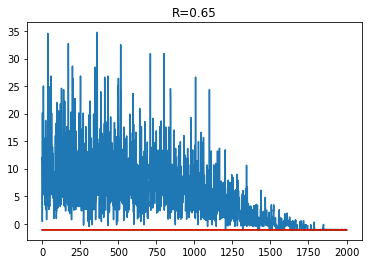

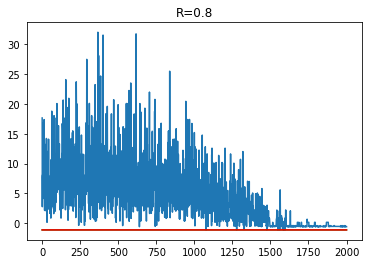

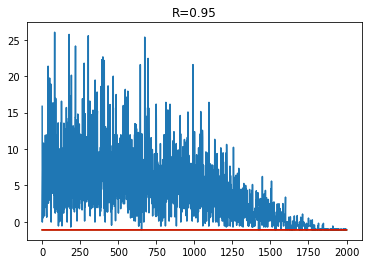

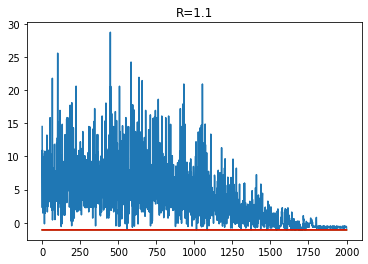

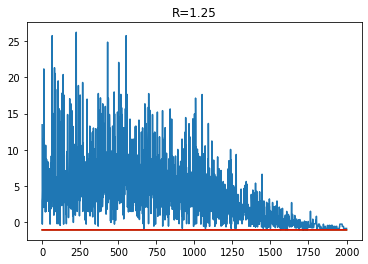

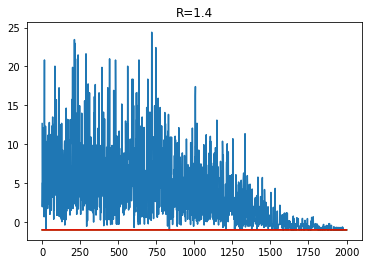

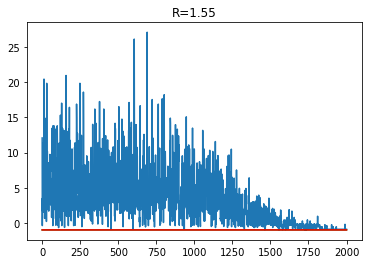

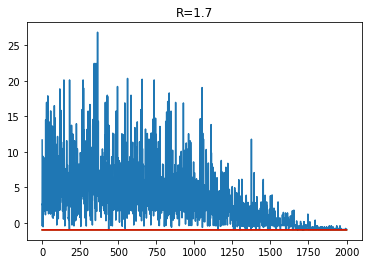

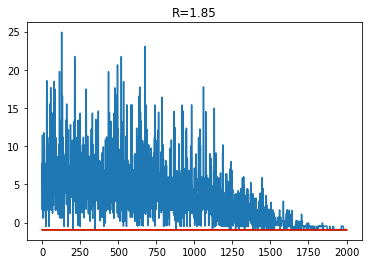

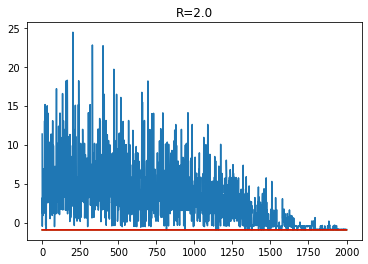

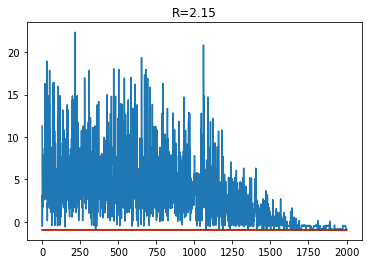

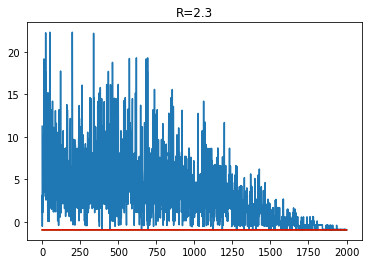

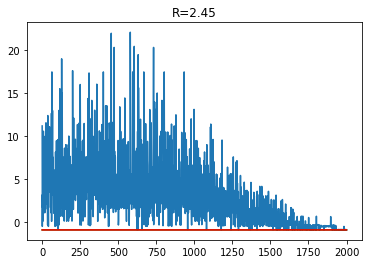

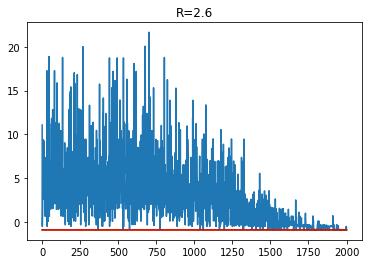

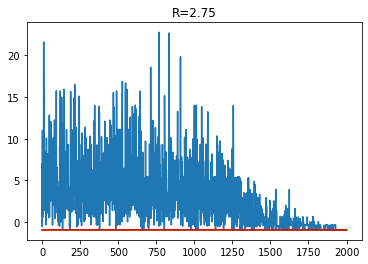

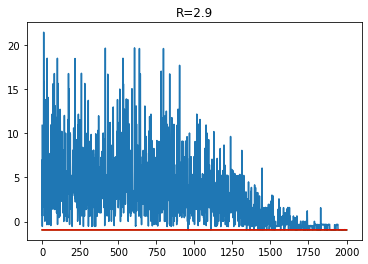

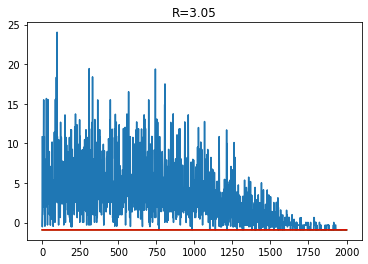

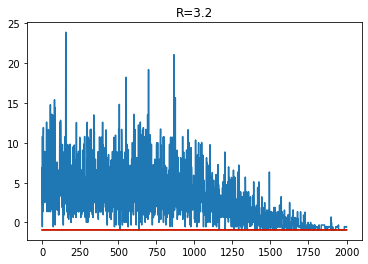

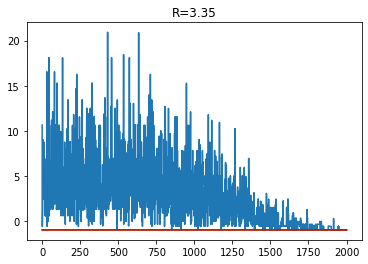

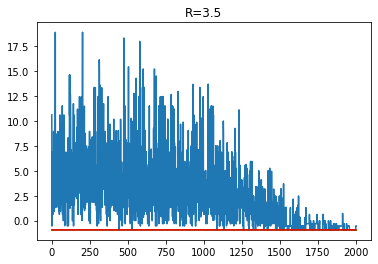

In [20]:
hamiltonians = [f for f in glob('hamiltonians/Ising-H2-STO-3G-bk-samespin-R=*.inp')]

df = pd.DataFrame(columns=["Ea(2-local)", "Et(2-local)"])
for hamiltonian_file in sorted(hamiltonians):
    match = re.match(r"hamiltonians/Ising-H2-STO-3G-bk-samespin-R=([\d.]+).inp", hamiltonian_file)
    r = float(match.groups(0)[0])
    E0, h, J, K, L = read_generalized_ising_hamiltonian(hamiltonian_file)
    expr = construct_hamiltonian_expr(E0, h, J, K, L)
    reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
    E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
    # This h/J can be directly used to hamiltonian for D-Wave
    ising = IsingModel2D(E0, h, J)
    Ea, Et = calc_once(ising, exp_schedule(500, 0.1, 2000), plot_title=f"R={r}")
    df.loc[r] = pd.Series({"Ea(2-local)": Ea, "Et(2-local)": Et})
    print("Difference to exact:", (Et - Ea))
df = df.sort_index()

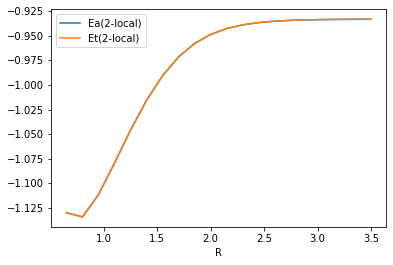

In [21]:
df.index.name = 'R'

# 300 iteration is not sufficient for this model
# ~2000 is sufficient
ax = df.plot()

In [16]:
class GeneralizedIsingModel(AbstractIsing):
    def __init__(self, E0, h, J, K, L, seed=0):
        super().__init__()
        self.E0 = E0
        self.h = h
        self.J = J
        self.K = K
        self.L = L
        np.random.seed(seed)
        self.num_spins = h.shape[0]
        self.spins = 2*(np.random.rand(self.num_spins) < 0.5) - 1

    def energy(self, spins=None):
        spins = self.spins if spins is None else spins

        interaction1d = spins.dot(self.h)
        interaction2d = spins.dot(self.J.dot(spins))
        interaction3d = np.einsum("ijk,i,j,k", self.K, spins, spins, spins)
        interaction4d = np.einsum("ijkl,i,j,k,l", self.L, spins, spins, spins, spins)

        return self.E0 + interaction1d + interaction2d + interaction3d + interaction4d

    def exact(self):
        n = len(self.spins)
        all_one = 2 ** n - 1
        E = np.inf
        for i in range(all_one + 1):
            spins = spinfield_1d(i, n)
            E = min(E, self.energy(spins))
        return E

    def energy_diff(self, i):
        diff1d = self.h[i]
        diff2d = self.J[i, :].dot(self.spins) + self.J[:, i].dot(self.spins)
        diff3d = self.spins.dot(self.K[i, :, :].dot(self.spins)) + \
                 self.spins.dot(self.K[:, i, :].dot(self.spins)) + \
                 self.spins.dot(self.K[:, :, i].dot(self.spins))
        diff4d = \
             np.einsum("jkl,j,k,l", self.L[i, :, :, :], self.spins, self.spins, self.spins) + \
             np.einsum("ikl,i,k,l", self.L[:, i, :, :], self.spins, self.spins, self.spins) + \
             np.einsum("ijl,i,j,l", self.L[:, :, i, :], self.spins, self.spins, self.spins) + \
             np.einsum("ijk,i,j,k", self.L[:, :, :, i], self.spins, self.spins, self.spins)

        return -2 * self.spins[i] * (diff1d + diff2d + diff3d + diff4d)

    def rand_site(self):
        return (np.random.randint(self.num_spins),)

In [ ]:
hamiltonians = [f for f in glob('hamiltonians/Ising-H2-STO-3G-bk-samespin-R=*.inp')]

df2 = pd.DataFrame(columns=["Ea(4-local)", "Et(4-local)"])
for hamiltonian_file in sorted(hamiltonians):
    match = re.match(r"hamiltonians/Ising-H2-STO-3G-bk-samespin-R=([\d.]+).inp", hamiltonian_file)
    r = float(match.groups(0)[0])
    E0, h, J, K, L = read_generalized_ising_hamiltonian(hamiltonian_file)
    ising = GeneralizedIsingModel(E0, h, J, K, L)
    Ea, Et = calc_once(ising, exp_schedule(400, 0.1, 300), plot_title=f"R={r}")
    df2.loc[r] = pd.Series({"Ea(4-local)": Ea, "Et(4-local)": Et})
df2 = df2.sort_index()
df2

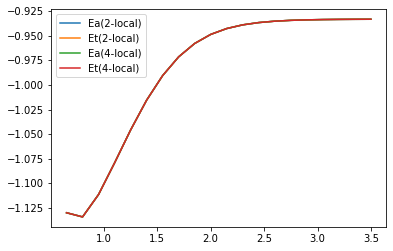

In [42]:

df3 = pd.concat([df, df2])
df3.plot()


### Using same annealing steps as 4-local, 2-local does not well converge

Exact:  -1.1299047752322915
Difference to exact: 4.440892098500626e-16
Exact:  -1.1341476722233885
Difference to exact: -0.5369699217485837
Exact:  -1.1113394317141143
Difference to exact: -0.39463726424121537
Exact:  -1.0791929635915078
Difference to exact: -0.1634171878021502
Exact:  -1.0457831649744032
Difference to exact: -2.220446049250313e-16
Exact:  -1.0154682691531134
Difference to exact: -0.1400403451055552
Exact:  -0.9904763585526108
Difference to exact: -0.09381303818552533
Exact:  -0.9714267029717623
Difference to exact: 6.661338147750939e-16
Exact:  -0.9578329791835558
Difference to exact: -0.011128506090006485
Exact:  -0.9486411206967023
Difference to exact: 1.3322676295501878e-15
Exact:  -0.94267779203203
Difference to exact: 1.1102230246251565e-16
Exact:  -0.938922390740256
Difference to exact: -0.008863752227242339
Exact:  -0.9366052600789354
Difference to exact: 0.0
Exact:  -0.9351960337828169
Difference to exact: -0.003089932756835223
Exact:  -0.9343489902069892
Diff

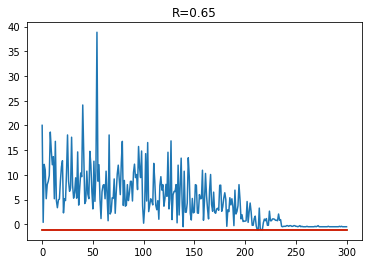

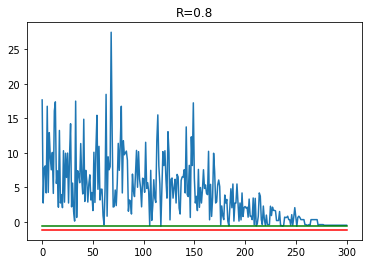

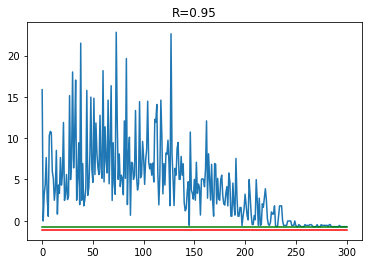

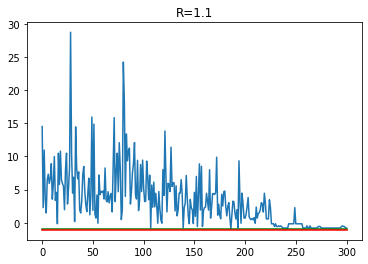

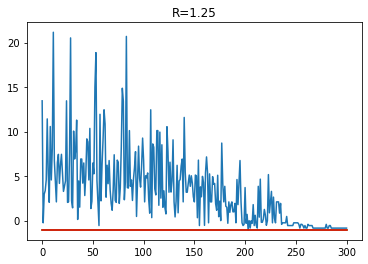

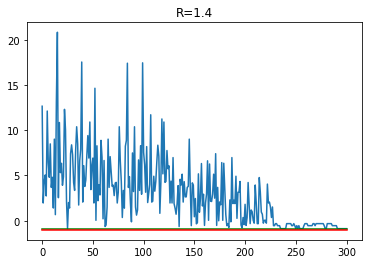

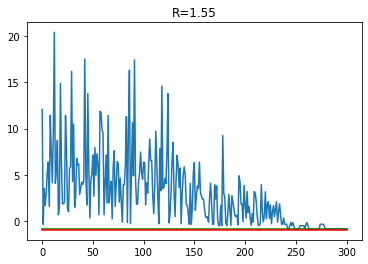

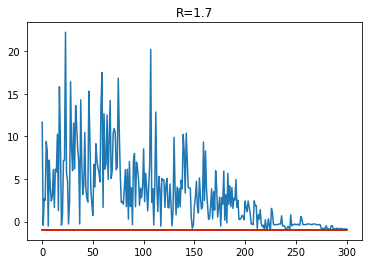

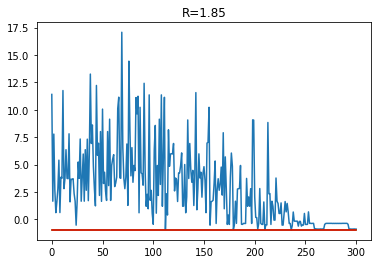

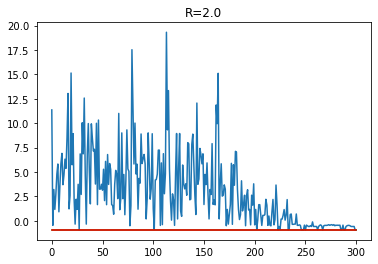

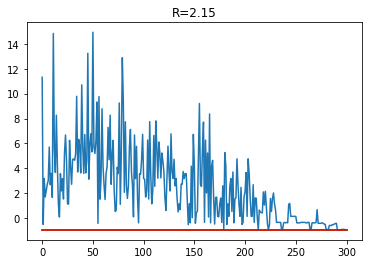

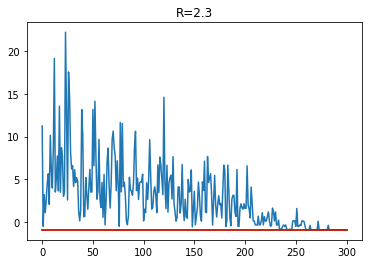

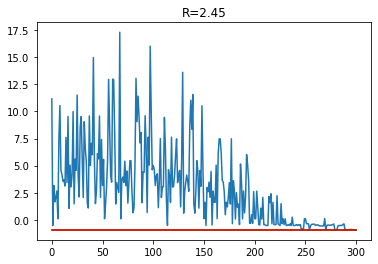

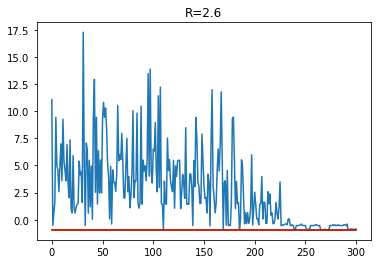

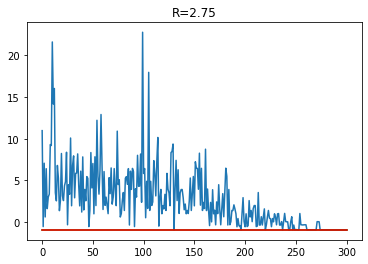

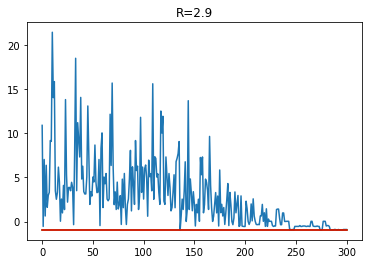

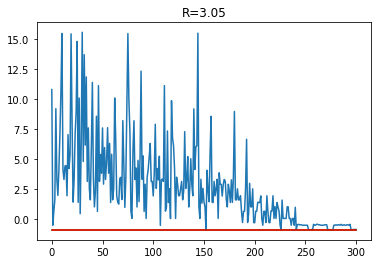

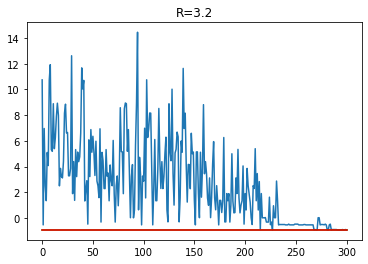

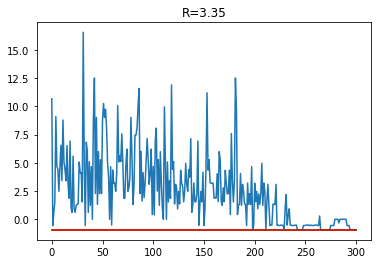

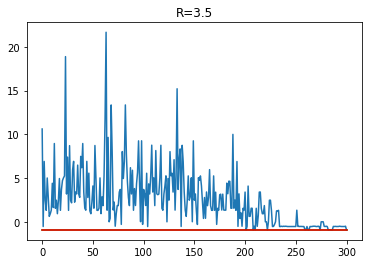

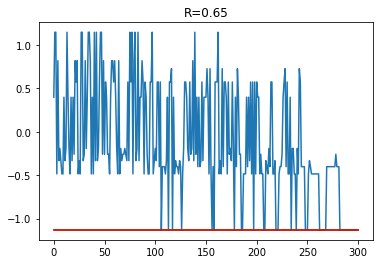

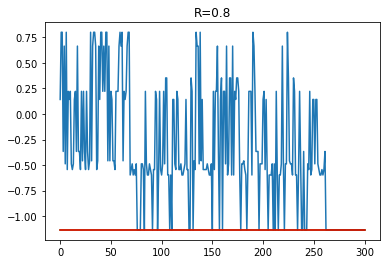

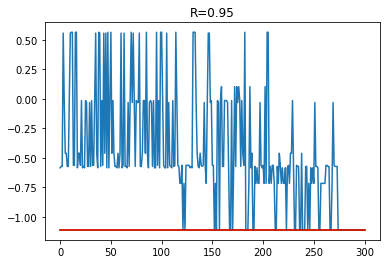

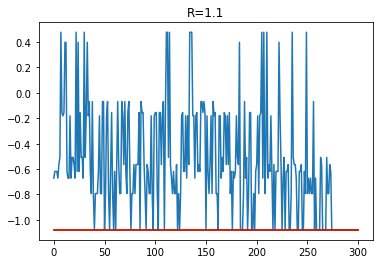

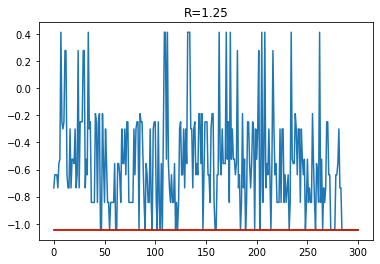

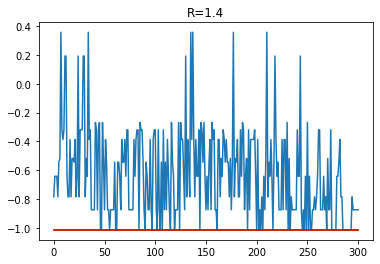

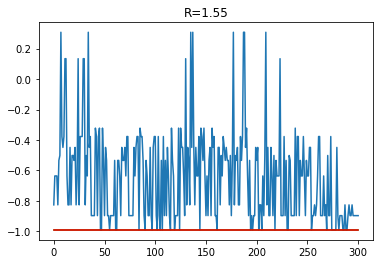

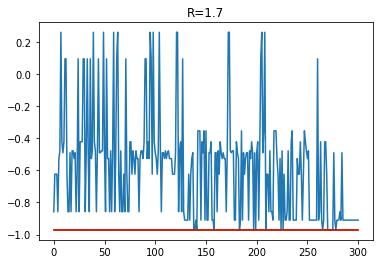

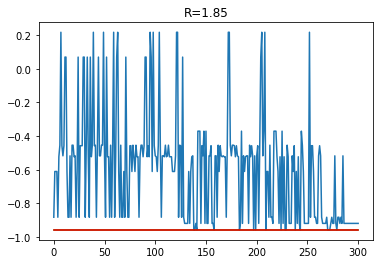

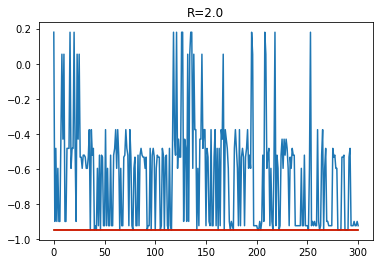

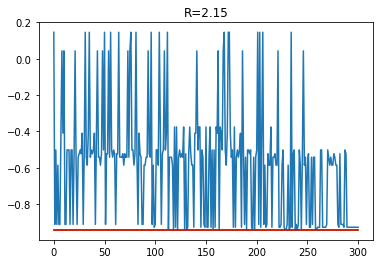

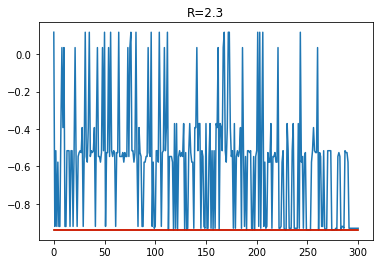

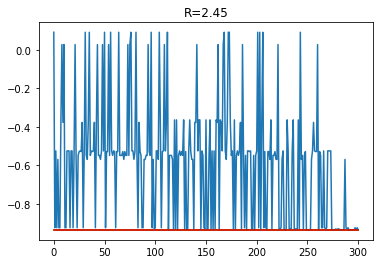

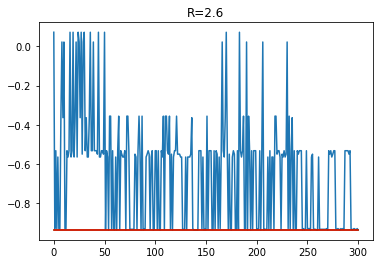

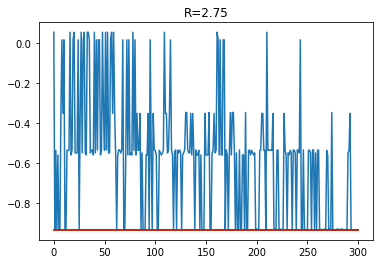

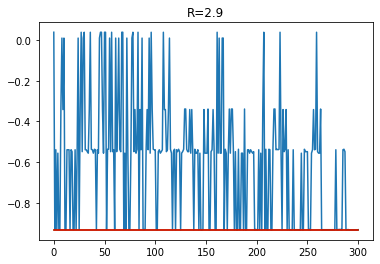

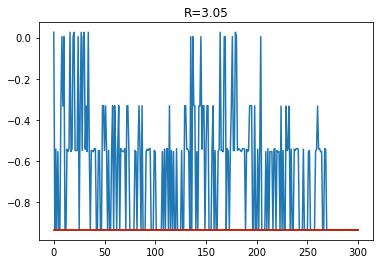

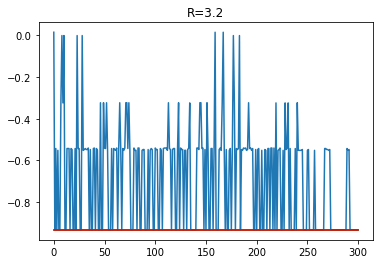

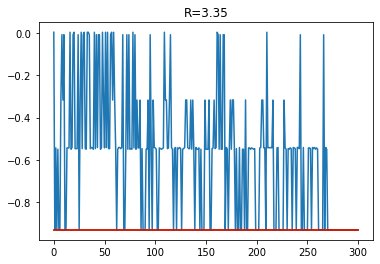

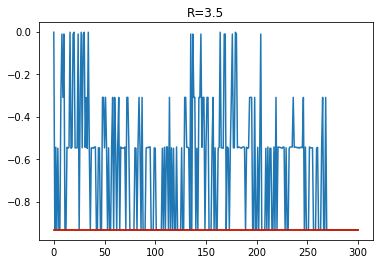

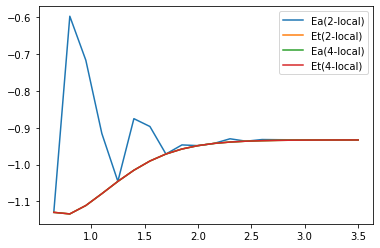

In [17]:
hamiltonians = [f for f in glob('hamiltonians/Ising-H2-STO-3G-bk-samespin-R=*.inp')]

df = pd.DataFrame(columns=["Ea(2-local)", "Et(2-local)"])
for hamiltonian_file in sorted(hamiltonians):
    match = re.match(r"hamiltonians/Ising-H2-STO-3G-bk-samespin-R=([\d.]+).inp", hamiltonian_file)
    r = float(match.groups(0)[0])
    E0, h, J, K, L = read_generalized_ising_hamiltonian(hamiltonian_file)
    expr = construct_hamiltonian_expr(E0, h, J, K, L)
    reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
    E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
    # This h/J can be directly used to hamiltonian for D-Wave
    ising = IsingModel2D(E0, h, J)
    Ea, Et = calc_once(ising, exp_schedule(400, 0.1, 300), plot_title=f"R={r}")
    df.loc[r] = pd.Series({"Ea(2-local)": Ea, "Et(2-local)": Et})
    print("Difference to exact:", (Et - Ea))
df = df.sort_index()

df2 = pd.DataFrame(columns=["Ea(4-local)", "Et(4-local)"])
for hamiltonian_file in sorted(hamiltonians):
    match = re.match(r"hamiltonians/Ising-H2-STO-3G-bk-samespin-R=([\d.]+).inp", hamiltonian_file)
    r = float(match.groups(0)[0])
    E0, h, J, K, L = read_generalized_ising_hamiltonian(hamiltonian_file)
    ising = GeneralizedIsingModel(E0, h, J, K, L)
    Ea, Et = calc_once(ising, exp_schedule(400, 0.1, 300), plot_title=f"R={r}")
    df2.loc[r] = pd.Series({"Ea(4-local)": Ea, "Et(4-local)": Et})
df2 = df2.sort_index()
df2

df3 = pd.concat([df, df2])
df3.plot()


### Discussion about 2-local reduction

- Sufficient annealing steps increases from O(100) to O(1000), which seems to be affected by complex energy landscape of reduced hamiltonian.

## D-Wave Solvers

- Try hybrid solver
 - This shows almost the same behavior compared to our implementation (Time / Accuarcy)
 - Comparing implementation detail against D-Wave neal, differences are.
   - It uses same local-update strategy (Matropolis-Hastings)
   - It is implemented using C++ and optimize random number generation using macro

   - It pre-calculates energy differences by a spin flip, and caches them
   - It also does pruning of energy difference calculation
 - What to be mentioned here is
   - It still does local update, so global update algorithm such as Swendsen-Wang should be considered for implementation

In [33]:
import dimod

def build_bqm_from_interaction_tensors(h, J):
    linear_coeffs = {}
    for i in range(h.shape[0]):
        linear_coeffs[i]  = h[i]

    quadratic_coeffs = {}
    for i in range(J.shape[0]):
        for j in range(J.shape[1]):
            quadratic_coeffs [(i, j)] = J[i, j]

    bqm = dimod.BinaryQuadraticModel(linear_coeffs, quadratic_coeffs, vartype='SPIN')
    return bqm

E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")
expr = construct_hamiltonian_expr(E0, h, J, K, L)
reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
bqm = build_bqm_from_interaction_tensors(h, J)

In [34]:
from dwave.system import LeapHybridSampler
sampler = LeapHybridSampler()    # doctest: +SKIP
answer = sampler.sample(bqm)   # doctest: +SKIP
print(answer)    # doctest: +SKIP

   0  1  2  3  4  5  6  7  8  9 10 11     energy num_oc.
0 +1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -10.239748       1
['SPIN', 1 rows, 1 samples, 12 variables]


In [37]:
energy = answer.lowest().to_pandas_dataframe().loc[0, 'energy'] + E0
energy

-1.12990477523230

In [36]:
type(energy)

pandas.core.series.Series


Do this for all $R$

In [38]:

hamiltonians = [f for f in glob('hamiltonians/Ising-H2-STO-3G-bk-samespin-R=*.inp')]
from dwave.system import LeapHybridSampler
sampler = LeapHybridSampler()    # doctest: +SKIP

df = pd.DataFrame(columns=["Ea(2-local, D-Wave hybrid)", "Et(2-local)"])
for hamiltonian_file in sorted(hamiltonians):
    match = re.match(r"hamiltonians/Ising-H2-STO-3G-bk-samespin-R=([\d.]+).inp", hamiltonian_file)
    r = float(match.groups(0)[0])
    E0, h, J, K, L = read_generalized_ising_hamiltonian(hamiltonian_file)
    expr = construct_hamiltonian_expr(E0, h, J, K, L)
    reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
    E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
    # This h/J can be directly used to hamiltonian for D-Wave
    ising = IsingModel2D(E0, h, J)
    Et = ising.exact()
    bqm = build_bqm_from_interaction_tensors(h, J)
    answer = sampler.sample(bqm)
    Ea = answer.lowest().to_pandas_dataframe().loc[0, 'energy'] + E0
    df.loc[r] = pd.Series({"Ea(2-local, D-Wave hybrid)": float(Ea), "Et(2-local)": Et})
    print("Difference to exact:", (Et - Ea))
df = df.sort_index()

Difference to exact: 1.15463194561016e-14
Difference to exact: 3.55271367880050e-15
Difference to exact: 2.48689957516035e-14
Difference to exact: 3.55271367880050e-15
Difference to exact: 4.44089209850063e-15
Difference to exact: -2.66453525910038e-15
Difference to exact: 4.44089209850063e-15
Difference to exact: -4.44089209850063e-16
Difference to exact: 2.22044604925031e-15
Difference to exact: -3.10862446895044e-15
Difference to exact: 1.77635683940025e-15
Difference to exact: 1.77635683940025e-14
Difference to exact: 8.88178419700125e-16
Difference to exact: -3.55271367880050e-15
Difference to exact: 3.55271367880050e-15
Difference to exact: 2.22044604925031e-15
Difference to exact: 8.88178419700125e-16
Difference to exact: 4.44089209850063e-15
Difference to exact: 4.44089209850063e-15
Difference to exact: 8.88178419700125e-16


In [45]:
df['Ea(2-local, D-Wave hybrid)'] = df['Ea(2-local, D-Wave hybrid)'].astype(float)

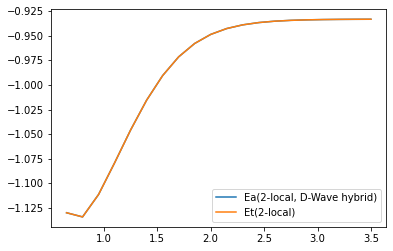

In [46]:
%matplotlib inline
df.plot()

### Try on D-Wave QPU
- `num_reads` is important
  - It does not well converge on O(1000), it needs O(10000) to converge
- Yet it actually obtains almost optimal result

In [48]:

from dwave.system import DWaveSampler, EmbeddingComposite

E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")
expr = construct_hamiltonian_expr(E0, h, J, K, L)
reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
bqm = build_bqm_from_interaction_tensors(h, J)
sampler = EmbeddingComposite(DWaveSampler())
answer = sampler.sample(bqm, num_reads=10000)
energy = answer.lowest().to_pandas_dataframe().loc[0, 'energy'] + E0
energy

-1.12990477523229

- Now try for all $R$s

In [49]:

hamiltonians = [f for f in glob('hamiltonians/Ising-H2-STO-3G-bk-samespin-R=*.inp')]
from dwave.system import LeapHybridSampler
sampler = EmbeddingComposite(DWaveSampler())

df = pd.DataFrame(columns=["Ea(2-local, D-Wave QPU)", "Et(2-local)"])
for hamiltonian_file in sorted(hamiltonians):
    match = re.match(r"hamiltonians/Ising-H2-STO-3G-bk-samespin-R=([\d.]+).inp", hamiltonian_file)
    r = float(match.groups(0)[0])
    E0, h, J, K, L = read_generalized_ising_hamiltonian(hamiltonian_file)
    expr = construct_hamiltonian_expr(E0, h, J, K, L)
    reduced_expr = reduce_locality(expr, variable_name='sigma', maximum_index=3, to_locality=2)
    E0, h, J = reconstruct_interaction_tensors_2_local(reduced_expr)
    # This h/J can be directly used to hamiltonian for D-Wave
    ising = IsingModel2D(E0, h, J)
    Et = ising.exact()
    bqm = build_bqm_from_interaction_tensors(h, J)
    answer = sampler.sample(bqm, num_reads=10000)
    Ea = answer.lowest().to_pandas_dataframe().loc[0, 'energy'] + E0
    df.loc[r] = pd.Series({"Ea(2-local, D-Wave QPU)": float(Ea), "Et(2-local)": Et})
    print("Difference to exact:", (Et - Ea))
df = df.sort_index()

Difference to exact: -8.88178419700125e-16
Difference to exact: -1.77635683940025e-15
Difference to exact: 1.77635683940025e-15
Difference to exact: -1.77635683940025e-15
Difference to exact: -8.88178419700125e-16
Difference to exact: -8.88178419700125e-16
Difference to exact: 1.77635683940025e-15
Difference to exact: -4.44089209850063e-16
Difference to exact: 1.33226762955019e-15
Difference to exact: -4.44089209850063e-16
Difference to exact: 0
Difference to exact: 0
Difference to exact: 0
Difference to exact: -8.88178419700125e-16
Difference to exact: 0
Difference to exact: -1.33226762955019e-15
Difference to exact: 8.88178419700125e-16
Difference to exact: 0
Difference to exact: 8.88178419700125e-16
Difference to exact: 0


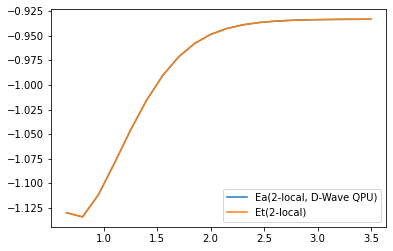

In [52]:
%matplotlib inline

In [ ]:
df.plot()

# Application to Geneome Multiple Alighment

- Sum-of-pairs (SP) alighment is [NP-Complete](https://www.liebertpub.com/doi/abs/10.1089/cmb.1994.1.337)
- We would like to work on this using annealing approach as discussed in [this paper](https://arxiv.org/abs/2004.06719)
- We used the [BAliBase 4](http://www.lbgi.fr/balibase/) R10 dataset
- In typical setup, this kind of problem is solved by finding Hamiltonian path on the overlap-layout-consensus (OLC) graph of raw genome reads.(Figure1 in the paper)
-